# Proof of concept: the Two-SNP example with missing data

This is the same notebook as the `two_snps_dispute.ipynb` but here I:

1. Add in a couple of missing values in `Y`
2. Use precomputed inverse matrices

I'd expect to see almost identical result indicating my implementation are correct.

In [1]:
%cd /home/gaow/tmp/13-May-2019

/home/gaow/Documents/TempDir/13-May-2019

## Find negatively correlation SNPs

In [2]:
genotype = readRDS('Multi_Tissues.ENSG00000145214.RDS')$X

In [3]:
ld = cor(genotype)

In [4]:
idx = which(ld > -0.855 & ld < -0.85, arr.ind = T)

In [5]:
head(idx)

,row,col
chr4_173807_A_G_b38,354,184
chr4_205767_C_CA_b38,454,184
chr4_205769_C_T_b38,455,184
chr4_196264_A_G_b38,417,233
chr4_196753_C_T_b38,420,266
chr4_199265_C_G_b38,427,293


So let's check out 184 and 354:

In [6]:
cor(genotype[,184], genotype[,354])

[1] -0.854587

In [7]:
colnames(genotype)[184]

[1] "chr4_112523_C_T_b38"

In [8]:
colnames(genotype)[354]

[1] "chr4_173807_A_G_b38"

## Simulate multivariate phenotypes

In [9]:
P = ncol(genotype)
R = 6
eff_factor = 1.5

In [10]:
set.seed(1)
b = matrix(0, P, R)
sharing = matrix(0.75, 3, 3)
diag(sharing) = 1

In [11]:
b[184, 1:3] = abs(MASS::mvrnorm(1, rep(0,3), sharing)) / eff_factor
b[354, 4:6] = -abs(MASS::mvrnorm(1, rep(0,3), sharing)) / eff_factor
print(b[184, 1:3])
print(b[354, 4:6])

[1] 0.1951948 0.3530102 0.5955379
[1] -1.136650 -1.039006 -0.736915


In [12]:
g = genotype %*% b

In [13]:
apply(g,2,sd) * eff_factor

[1] 0.2022533 0.3657754 0.6170732 1.1705304 1.0699760 0.7588805

In [14]:
e = MASS::mvrnorm(1, rep(0,R), diag(R) * 1)

In [15]:
Y = g + e

## Prepare MASH mixture prior

In [16]:
U1 = matrix(0,R,R)
U1[1:3,1:3] = sharing
U2 = matrix(0,R,R)
U2[4:6,4:6] = sharing
Ulist = list(U1=U1, U2=U2)
scaling = c(0.5,1) / eff_factor
mash_init = mmbr:::MashInitializer$new(Ulist, scaling, alpha = 0)

Notice here I'm using the EZ model by setting `alpha = 1`.

## Fit MV-SuSiE

With / without precomputed inverse matrices we compare the running time on this $R=6$ example,

In [17]:
start_time <- Sys.time()
res0 = mmbr::susie(genotype,Y,
                  L=10,V=mash_init,
                  precompute_covariances=FALSE,
                  compute_objective=FALSE)
end_time <- Sys.time()
print(end_time - start_time)

Time difference of 8.268599 mins


In [18]:
start_time <- Sys.time()
res = mmbr::susie(genotype,Y,
                  L=10,V=mash_init,
                  precompute_covariances=TRUE,
                  compute_objective=FALSE)
end_time <- Sys.time()
print(end_time - start_time)

Time difference of 7.475222 mins


In [19]:
snps = sub("_[A-Z]*_[A-Z]*_b38", "", colnames(genotype))

In [20]:
rownames(res$coef) = c('intercept', snps)

## Visualize results

In [25]:
pdf('susie_plot_toy.pdf', width=8, height=4)
susieR::susie_plot(res0,y='PIP', main = 'Cross-condition Posterior Inclusion Probability', xlab = 'SNP positions', add_legend = F)
dev.off()

png 
  2

In [26]:
p = mmbr::mmbr_plot(res0)

Suggested PDF canvas width: 3 height: 5.4 


In [27]:
pdf('mmbr_plot_toy.pdf', width = 8, height = 4)
print(p$plot)
dev.off()

png 
  2

> susie_plot_toy.pdf (31.5 KiB):

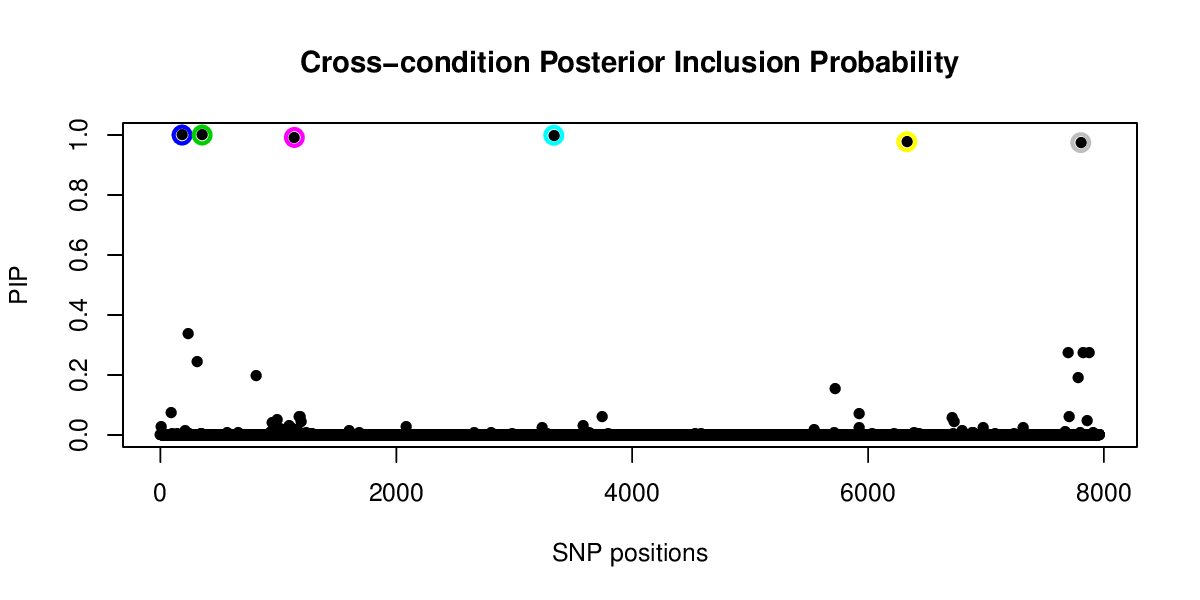

In [28]:
%preview susie_plot_toy.pdf -s png --dpi 150

> mmbr_plot_toy.pdf (5.6 KiB):

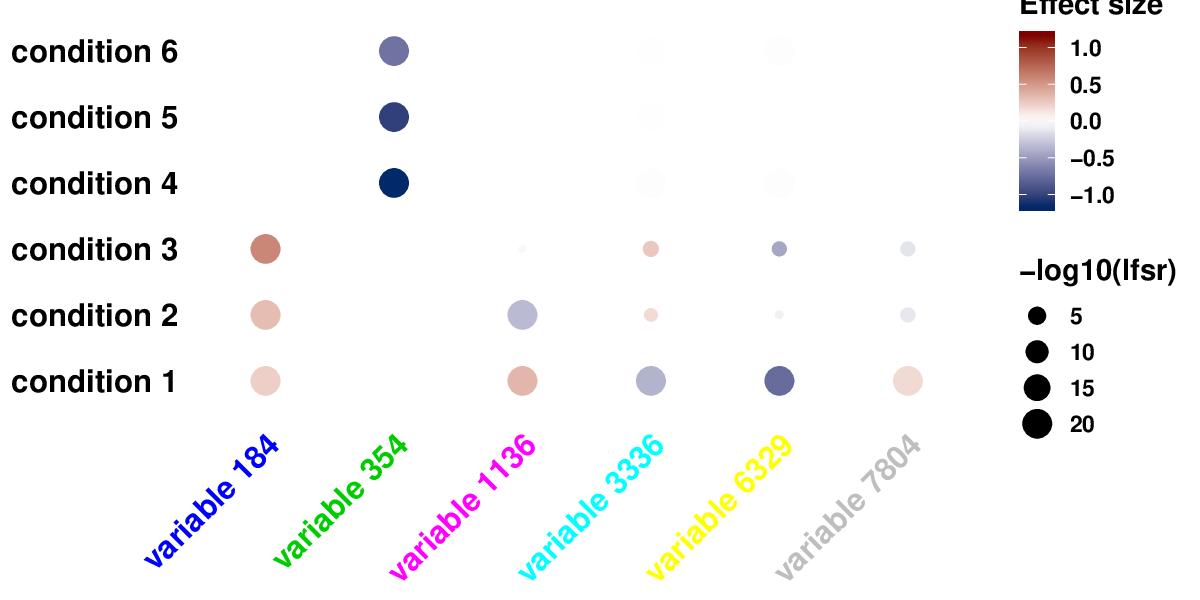

In [29]:
%preview mmbr_plot_toy.pdf -s png --dpi 150

Above looks all good. **Notice here I'm using the precompute covariances routine**.

## Add in some missing data

For each `Y` I want 5% data missing,

In [28]:
Y2 = Y
for (i in 1:ncol(Y)) {
    Y2[sample(1:nrow(Y), ceiling(nrow(Y) * 0.05)), i] = NA
}

And run the procedure again,

In [29]:
res = mmbr::susie(genotype,Y2,
                  L=10,V=mash_init,
                  precompute_covariances=TRUE,
                  compute_objective=FALSE)

In [30]:
snps = sub("_[A-Z]*_[A-Z]*_b38", "", colnames(genotype))
rownames(res$coef) = c('intercept', snps)

In [31]:
pdf('susie_plot_toy_missing.pdf', width=8, height=4)
susieR::susie_plot(res,y='PIP', main = 'Cross-condition Posterior Inclusion Probability', xlab = 'SNP positions', add_legend = F)
dev.off()

png 
  2

In [32]:
p = mmbr::mmbr_plot(res)

Suggested PDF canvas width: 8.5 height: 5.4 


In [33]:
pdf('mmbr_plot_toy_missing.pdf', width = 8, height = 4)
print(p$plot)
dev.off()

png 
  2

> susie_plot_toy_missing.pdf (25.9 KiB):

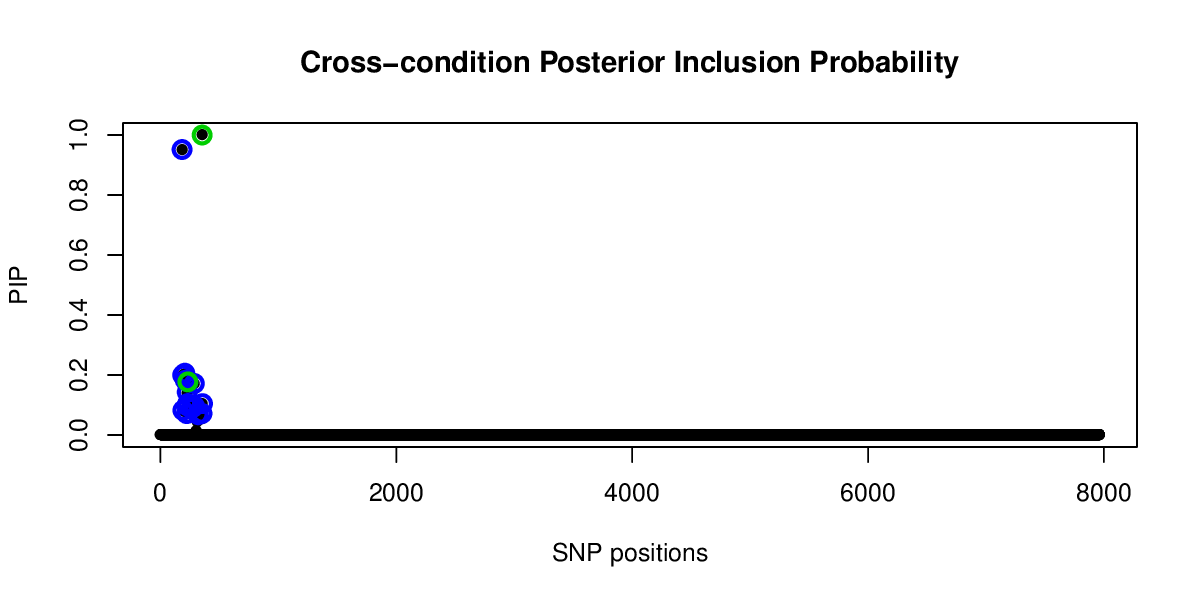

In [34]:
%preview susie_plot_toy_missing.pdf -s png --dpi 150

> mmbr_plot_toy_missing.pdf (5.7 KiB):

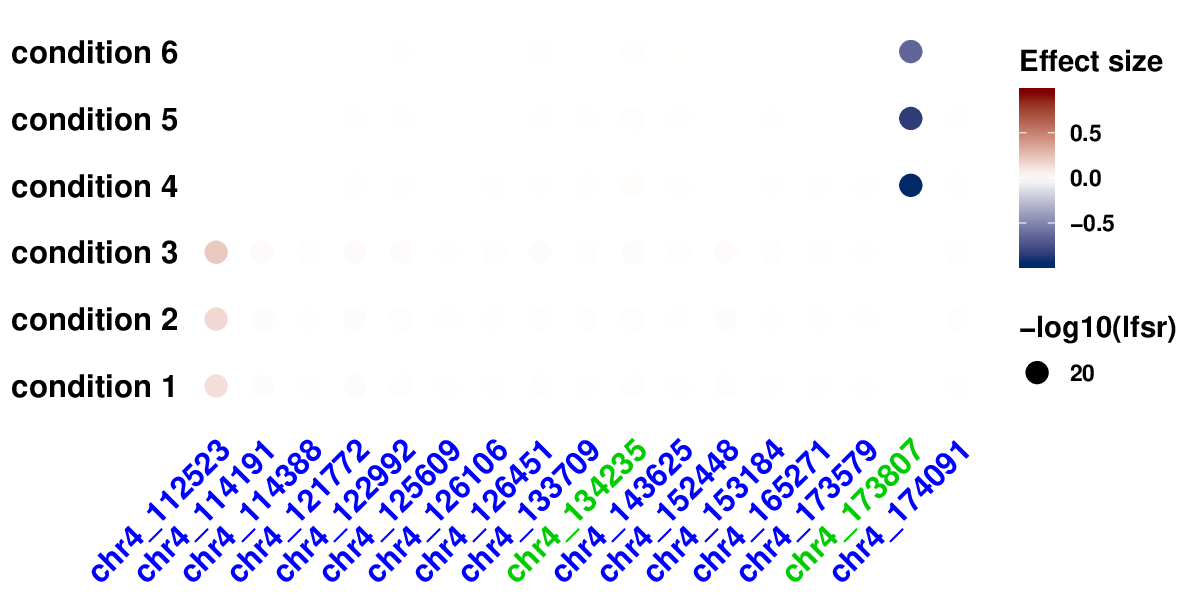

In [35]:
%preview mmbr_plot_toy_missing.pdf -s png --dpi 150